In [1]:
import sys

import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
    
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib_venn import venn3_unweighted
from matplotlib import rcParams
import matplotlib.font_manager
from matplotlib.pyplot import rc_context
    
import seaborn as sns
    
sc.set_figure_params(dpi=100, figsize=(4,4))
    
from bioinfokit import analys, visuz
    
from PIL import Image
    
import scanpy.external as sce
    
import igraph as ig
import leidenalg as lg
import scipy
from scipy.stats import zscore
from scipy.spatial.distance import pdist, squareform
from scipy import sparse
    
modules = dir()
!pip list

Package                       Version
----------------------------- -----------
adjustText                    1.2.0
anndata                       0.9.1
anyio                         3.6.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
asttokens                     2.2.1
atactk                        0.1.6
attrs                         23.1.0
Babel                         2.12.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.12.2
bioinfokit                    2.1.3
bleach                        6.0.0
brotlipy                      0.7.0
cached-property               1.5.2
certifi                       2024.7.4
cffi                          1.15.1
charset-normalizer            3.1.0
colorama                      0.4.6
comm                          0.1.3
contourpy                     1.0.7
cryptography                  40.0.2
cycler                        0.11.0
debugpy                       1.6.7
decorator

In [2]:
arjun = sc.read_10x_mtx("../../single_cell/arjun/outs/filtered_feature_bc_matrix")
nigel_1 = sc.read_10x_mtx("../../single_cell/nigel_1/outs/filtered_feature_bc_matrix")
nigel_2 = sc.read_10x_mtx("../../single_cell/nigel_2/outs/filtered_feature_bc_matrix")
garca_1 = sc.read_10x_mtx("../../single_cell/garca_1/outs/filtered_feature_bc_matrix")
garca_2 = sc.read_10x_mtx("../../single_cell/garca_2/outs/filtered_feature_bc_matrix")

/Users/rarjun/.conda/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/rarjun/.conda/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/rarjun/.conda/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/rarjun/.conda/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/rarjun/.conda/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationW

In [3]:
adata = arjun.concatenate(nigel_1, nigel_2, garca_1, garca_2)
adata.var_names_make_unique()
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var["mt"] = adata.var_names.str.startswith("mt:")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
sc.pp.normalize_total(adata, target_sum=1e6, key_added="size_factor", layers=None)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=2000)
sc.tl.pca(adata, svd_solver='arpack', n_comps=50, random_state=0) 
sc.pp.neighbors(adata, n_neighbors=20, random_state=0)

/Users/rarjun/.conda/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/Users/rarjun/.conda/envs/scanpy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sce.pp.harmony_integrate(adata, key = 'batch', max_iter_harmony = 20)
sc.pp.neighbors(adata, n_neighbors=20, random_state=0, use_rep = "X_pca_harmony")
sc.tl.umap(adata, random_state=0, init_pos="spectral")
sc.tl.leiden(adata, resolution=1, random_state=0)

2025-08-18 11:39:18,547 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-18 11:39:25,067 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-18 11:39:25,143 - harmonypy - INFO - Iteration 1 of 20
2025-08-18 11:39:30,061 - harmonypy - INFO - Iteration 2 of 20
2025-08-18 11:39:34,915 - harmonypy - INFO - Iteration 3 of 20
2025-08-18 11:39:39,844 - harmonypy - INFO - Iteration 4 of 20
2025-08-18 11:39:44,701 - harmonypy - INFO - Iteration 5 of 20
2025-08-18 11:39:49,628 - harmonypy - INFO - Iteration 6 of 20
2025-08-18 11:39:54,478 - harmonypy - INFO - Iteration 7 of 20
2025-08-18 11:39:59,408 - harmonypy - INFO - Iteration 8 of 20
2025-08-18 11:40:02,768 - harmonypy - INFO - Converged after 8 iterations


In [5]:
genes = ['fru', 'pnt', 'erm', 'ase', 'dpn', 'dap', 'Sp1', 'Hey', 'nSyb', 'opa', 'repo']

adata_use = adata.raw if adata.raw is not None else adata

# Extract expression data for the specified genes
expr_data = adata_use.to_df()[genes]

expr_pos = expr_data >= 0.5
expr_neg = expr_data < 0.5

# Initialize cell type annotations with 'Unannotated'
cell_types = pd.Series('Unannotated', index=expr_data.index)

# Type II NB: fru+, pnt+, dpn+, erm-, ase-
condition = expr_pos['dpn'] & expr_pos['fru'] & expr_pos['pnt'] & expr_neg['erm'] & expr_neg['ase'] & expr_neg['repo']
cell_types[condition] = 'Type II NB'

# imm ase- INP: fru-, pnt+, erm+, ase-, dpn-, opa-, dap-
condition = expr_neg['fru'] & expr_pos['pnt'] & expr_pos['erm'] &  expr_neg['ase'] & expr_neg['dpn'] & expr_neg['opa'] & expr_neg['dap'] & expr_neg['repo']
cell_types[condition] = 'imm ase- INP'

# imm ase+ INP: fru-, pnt+, erm+, dpn-, opa-, dap-
condition = expr_neg['fru'] & expr_pos['pnt'] & expr_pos['erm'] &  expr_pos['ase'] & expr_neg['dpn'] & expr_neg['opa'] & expr_neg['dap'] & expr_neg['repo']
cell_types[condition] = 'imm ase+ INP'

# INP: dpn+, ase+, fru-, opa+, dap-
condition = expr_pos['dpn'] & expr_pos['ase'] & expr_neg['fru'] & expr_pos['opa'] & expr_neg['dap'] & expr_neg['repo']
cell_types[condition] = 'INP'

# Type I NB: fru+, ase+, dpn+, pnt-, erm-
condition = expr_pos['fru'] & expr_pos['ase'] & expr_pos['dpn'] & expr_neg['pnt'] & expr_neg['repo'] & expr_neg['erm']
cell_types[condition] = 'Type I NB'

# Type I GMC: dpn-, ase+, Sp1-, opa+
condition = expr_neg['dpn'] & expr_pos['ase'] & expr_neg['Sp1'] & expr_pos['opa'] & expr_neg['repo']
cell_types[condition] = 'Type I GMC'

# Type II GMC: dpn-, ase+, Sp1+, opa+
condition = expr_neg['dpn'] & expr_pos['ase'] & expr_pos['Sp1'] & expr_pos['opa'] & expr_neg['repo']
cell_types[condition] = 'Type II GMC'

# imm Neurons: Hey+, fru-, ase-
condition = expr_pos['Hey'] & expr_neg['fru'] & expr_neg['ase'] & expr_neg['repo']
cell_types[condition] = 'imm Neurons'

# Neurons: nSyb+, ase-
condition = expr_pos['nSyb'] & expr_neg['ase'] & expr_neg['repo']
cell_types[condition] = 'Neurons'

adata.obs['cell_type'] = cell_types

print(adata.obs['cell_type'].value_counts())


cell_type
Unannotated     15192
Neurons          6419
imm Neurons      2327
Type I NB        1161
INP               472
Type I GMC        456
Type II GMC       273
Type II NB        130
imm ase+ INP      116
imm ase- INP       80
Name: count, dtype: int64


In [6]:
adata_filtered = adata[adata.obs['cell_type'] != 'Unannotated'].copy()
sc.pp.highly_variable_genes(adata_filtered, flavor="cell_ranger", n_top_genes=2000)
sc.tl.pca(adata_filtered, svd_solver='arpack', n_comps=50, random_state=0) 
sc.pp.neighbors(adata_filtered, n_neighbors=20, random_state=0)
sce.pp.harmony_integrate(adata_filtered, key = 'batch', max_iter_harmony = 20)
sc.pp.neighbors(adata_filtered, n_neighbors=20, random_state=0, use_rep = "X_pca_harmony")
sc.tl.umap(adata_filtered, random_state=0, init_pos="spectral")
sc.tl.leiden(adata_filtered, resolution=1, random_state=0)

2025-08-18 11:40:35,296 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-18 11:40:38,621 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-18 11:40:38,646 - harmonypy - INFO - Iteration 1 of 20
2025-08-18 11:40:40,436 - harmonypy - INFO - Iteration 2 of 20
2025-08-18 11:40:42,193 - harmonypy - INFO - Iteration 3 of 20
2025-08-18 11:40:44,000 - harmonypy - INFO - Iteration 4 of 20
2025-08-18 11:40:45,797 - harmonypy - INFO - Converged after 4 iterations


/Users/rarjun/.conda/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


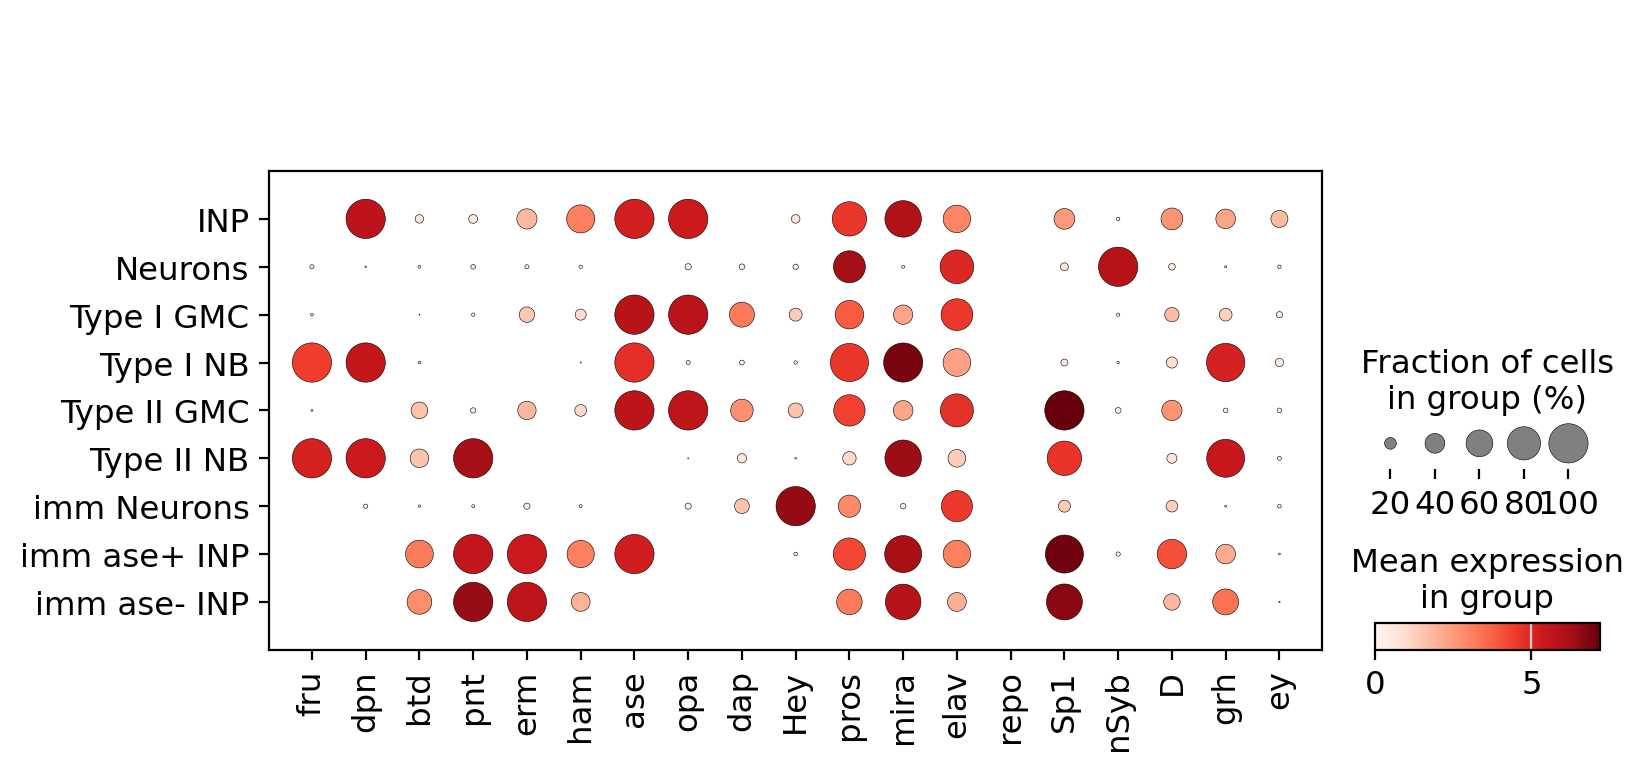

In [7]:
sc.pl.dotplot(adata_filtered, var_names=['fru', 'dpn', 'btd', 'pnt',
                                         'erm', 'ham', 'ase', 'opa',
                                         'dap', 'Hey', 'pros', 'mira',
                                         'elav', 'repo', 'Sp1', 'nSyb',
                                         'D', 'grh', 'ey'],groupby = 'cell_type')

In [8]:
thresh = 0.2
cell_type_gene_sets = {}

for cell_type in adata_filtered.obs['cell_type'].unique():
    adata_subset = adata_filtered[adata_filtered.obs['cell_type'] == cell_type]
    X = adata_subset.X
    var_names = adata_subset.var_names
    
    if sparse.issparse(X):
        X = X.toarray()
    
    expr_bool = X > 0
    
    fraction_expressed = np.mean(expr_bool, axis=0)
    genes_expressed = var_names[fraction_expressed > thresh]
    cell_type_gene_sets[cell_type] = set(genes_expressed)

In [9]:
def grouped_obs_mean(adata, group_key):
    getX = lambda x: x.layers["counts"]

    new_idx = adata.var['gene_ids'].index

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )
    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out
counts = grouped_obs_mean(adata_filtered, 'cell_type')

In [10]:
z_counts = counts[['Type II NB', 
                   'imm ase- INP', 
                   'imm ase+ INP', 
                   'INP',
                   'Type I GMC',
                   'Type II GMC',
                   'Type I NB']].apply(zscore, axis=1)

In [11]:
type_I_genes = set(z_counts[z_counts['Type I NB'] > 0].index.tolist()) & cell_type_gene_sets['Type I NB']
type_II_genes = set(z_counts[z_counts['Type II NB'] > 0].index.tolist()) & cell_type_gene_sets['Type II NB']
aseNeg_immINP_genes = set(z_counts[z_counts['imm ase- INP'] > 0].index.tolist()) & cell_type_gene_sets['imm ase- INP']
asePos_immINP_genes = set(z_counts[z_counts['imm ase+ INP'] > 0].index.tolist()) & cell_type_gene_sets['imm ase+ INP']
INP_genes = set(z_counts[z_counts['INP'] > 0].index.tolist()) & cell_type_gene_sets['INP']

In [12]:
tfs = pd.read_csv("../../single_cell/FB_TFs_9-23-24.txt", sep='\t')
tfs = set(tfs['SYMBOL'])

In [13]:
type_I_genes_TF = type_I_genes.intersection(tfs)
type_II_genes_TF = type_II_genes.intersection(tfs)
aseNeg_immINP_genes_TF = aseNeg_immINP_genes.intersection(tfs)
asePos_INP_genes_TF = asePos_immINP_genes.intersection(tfs)
INP_genes_TF = INP_genes.intersection(tfs)

In [14]:
def create_annotated_venn(set1, set2, set3, labels):
    plt.figure(figsize=(15, 15))
    venn = venn3_unweighted([set1, set2, set3], set_labels=labels)
    
    plt.title("Venn Diagram with Gene Annotations")
    plt.show()

/Users/rarjun/.conda/envs/scanpy/lib/python3.9/site-packages/matplotlib_venn/_util.py:62: UserWarning: venn3_unweighted is deprecated. Use venn3 with the appropriate layout_algorithm instead.
  warnings.warn(


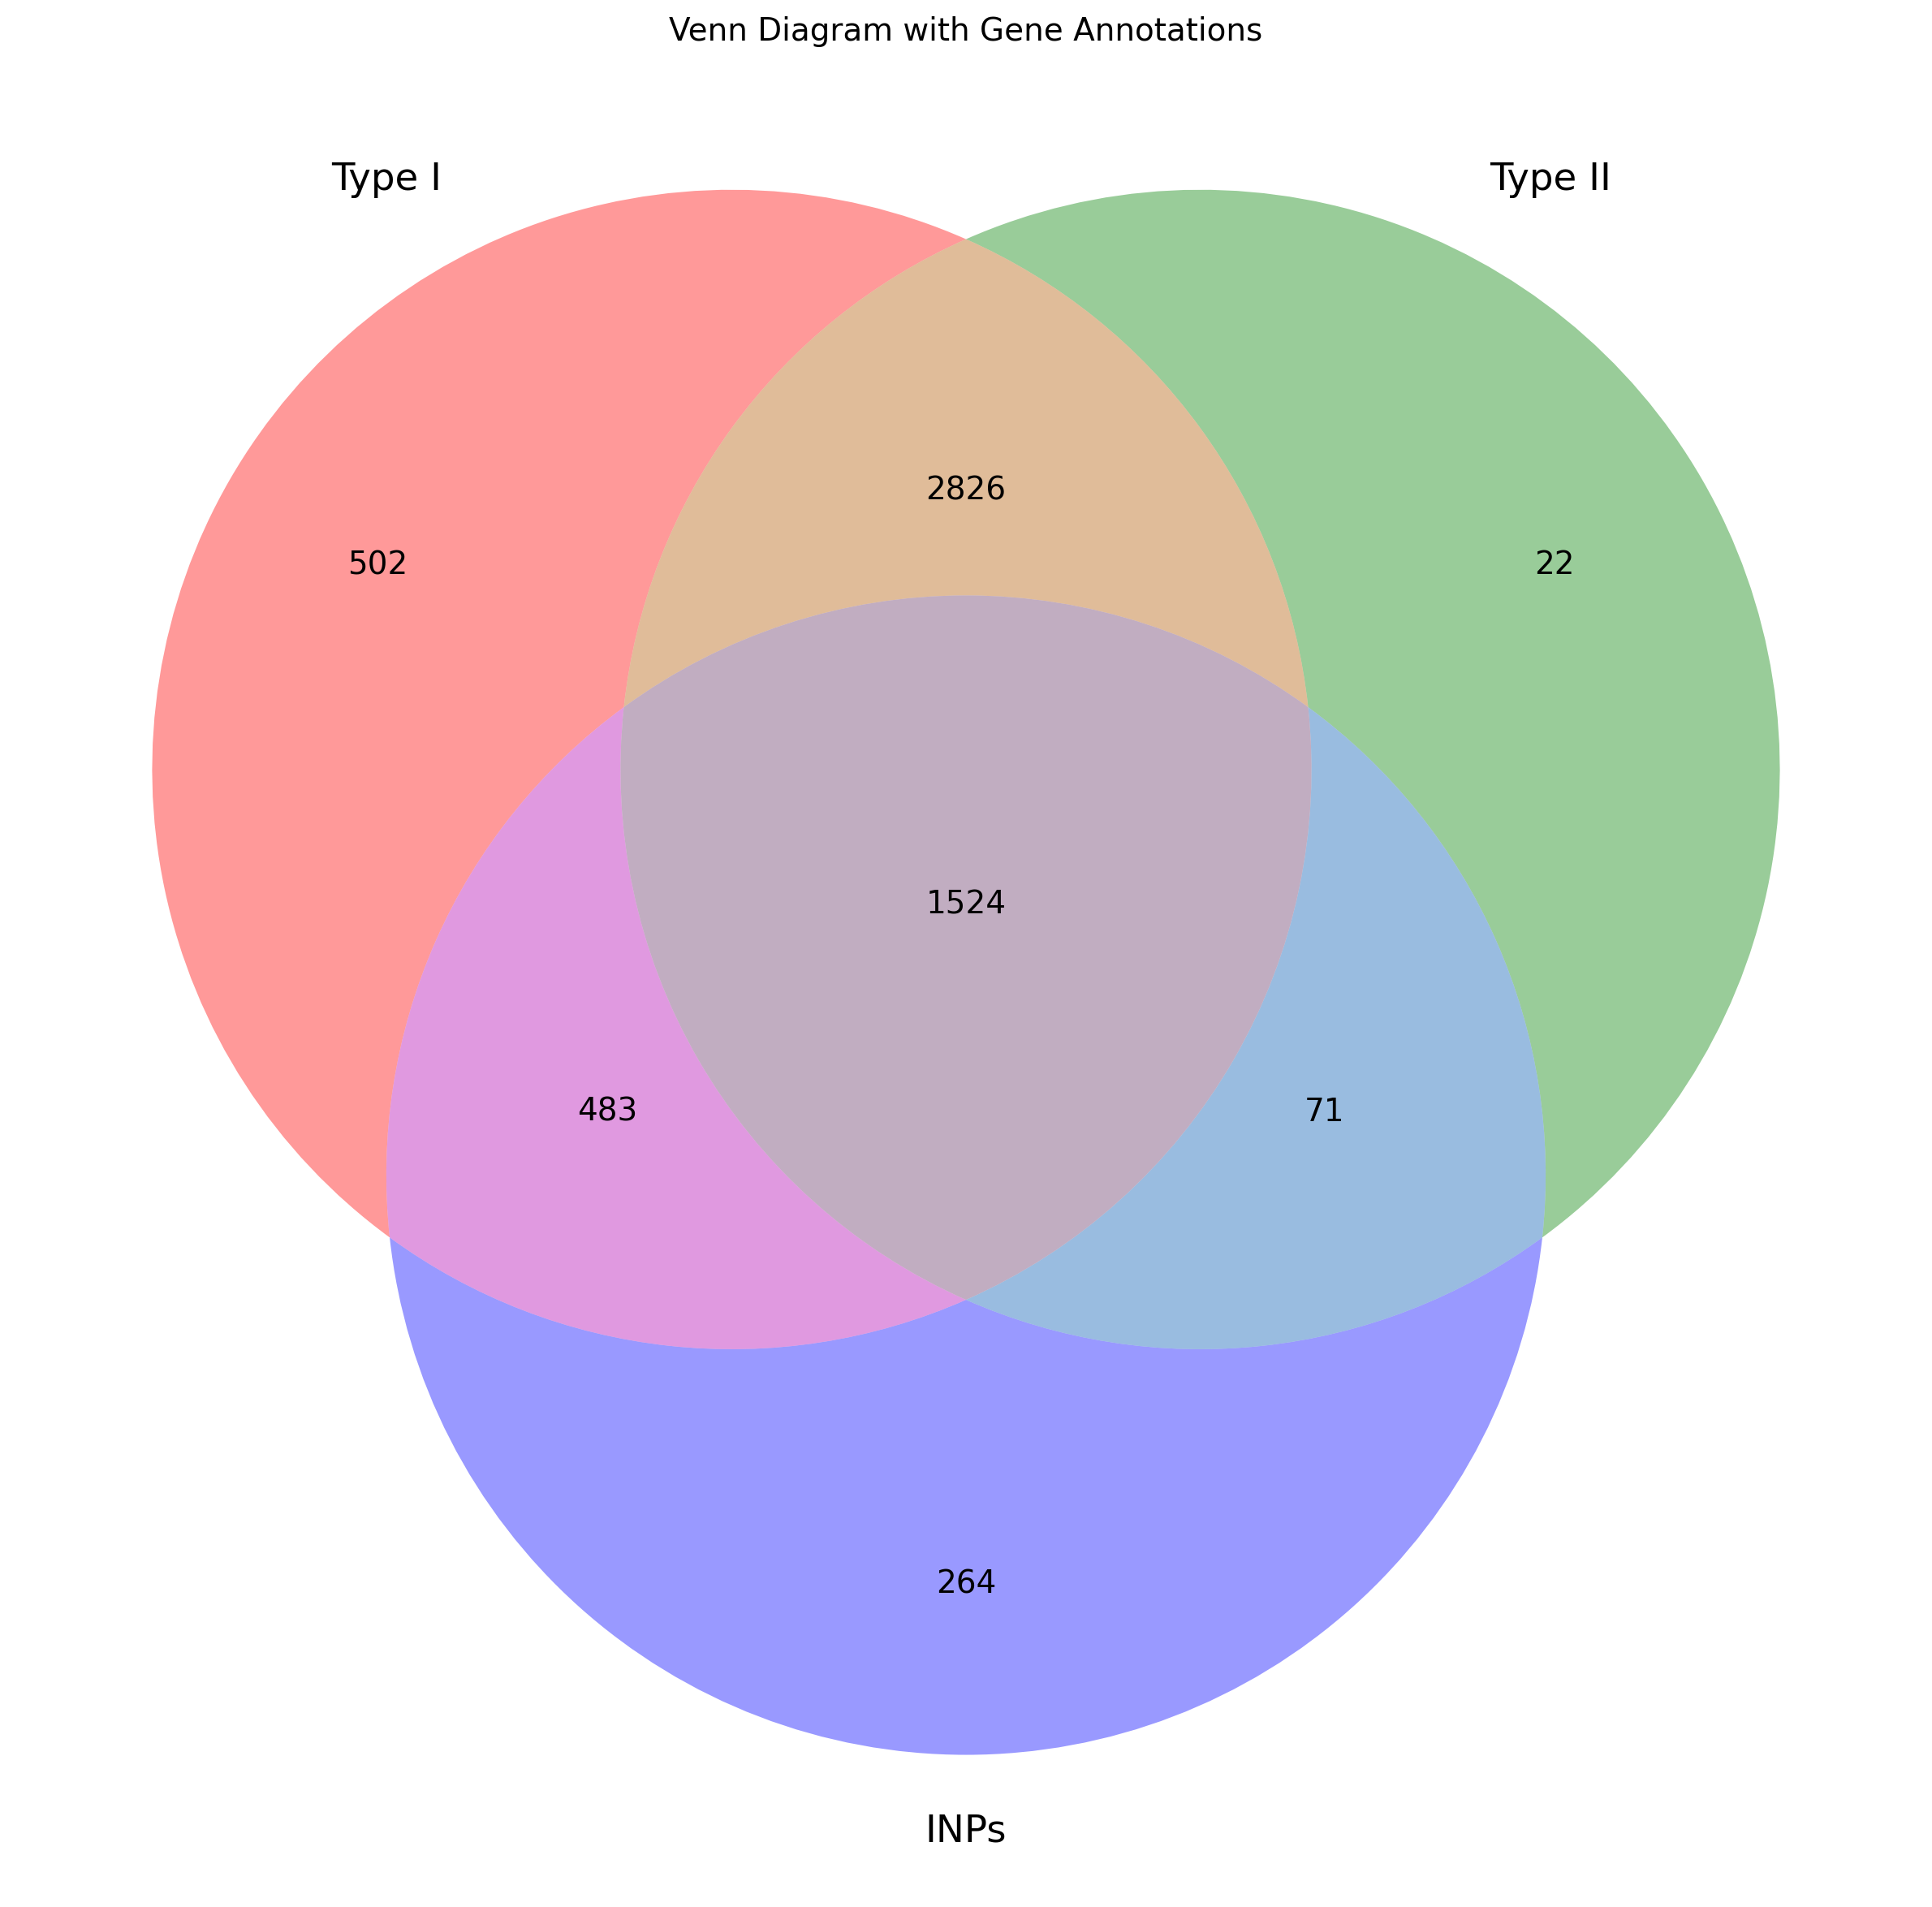

In [15]:
create_annotated_venn(type_I_genes, type_II_genes, asePos_immINP_genes.union(INP_genes), 
                      ('Type I', 'Type II', 'INPs'))

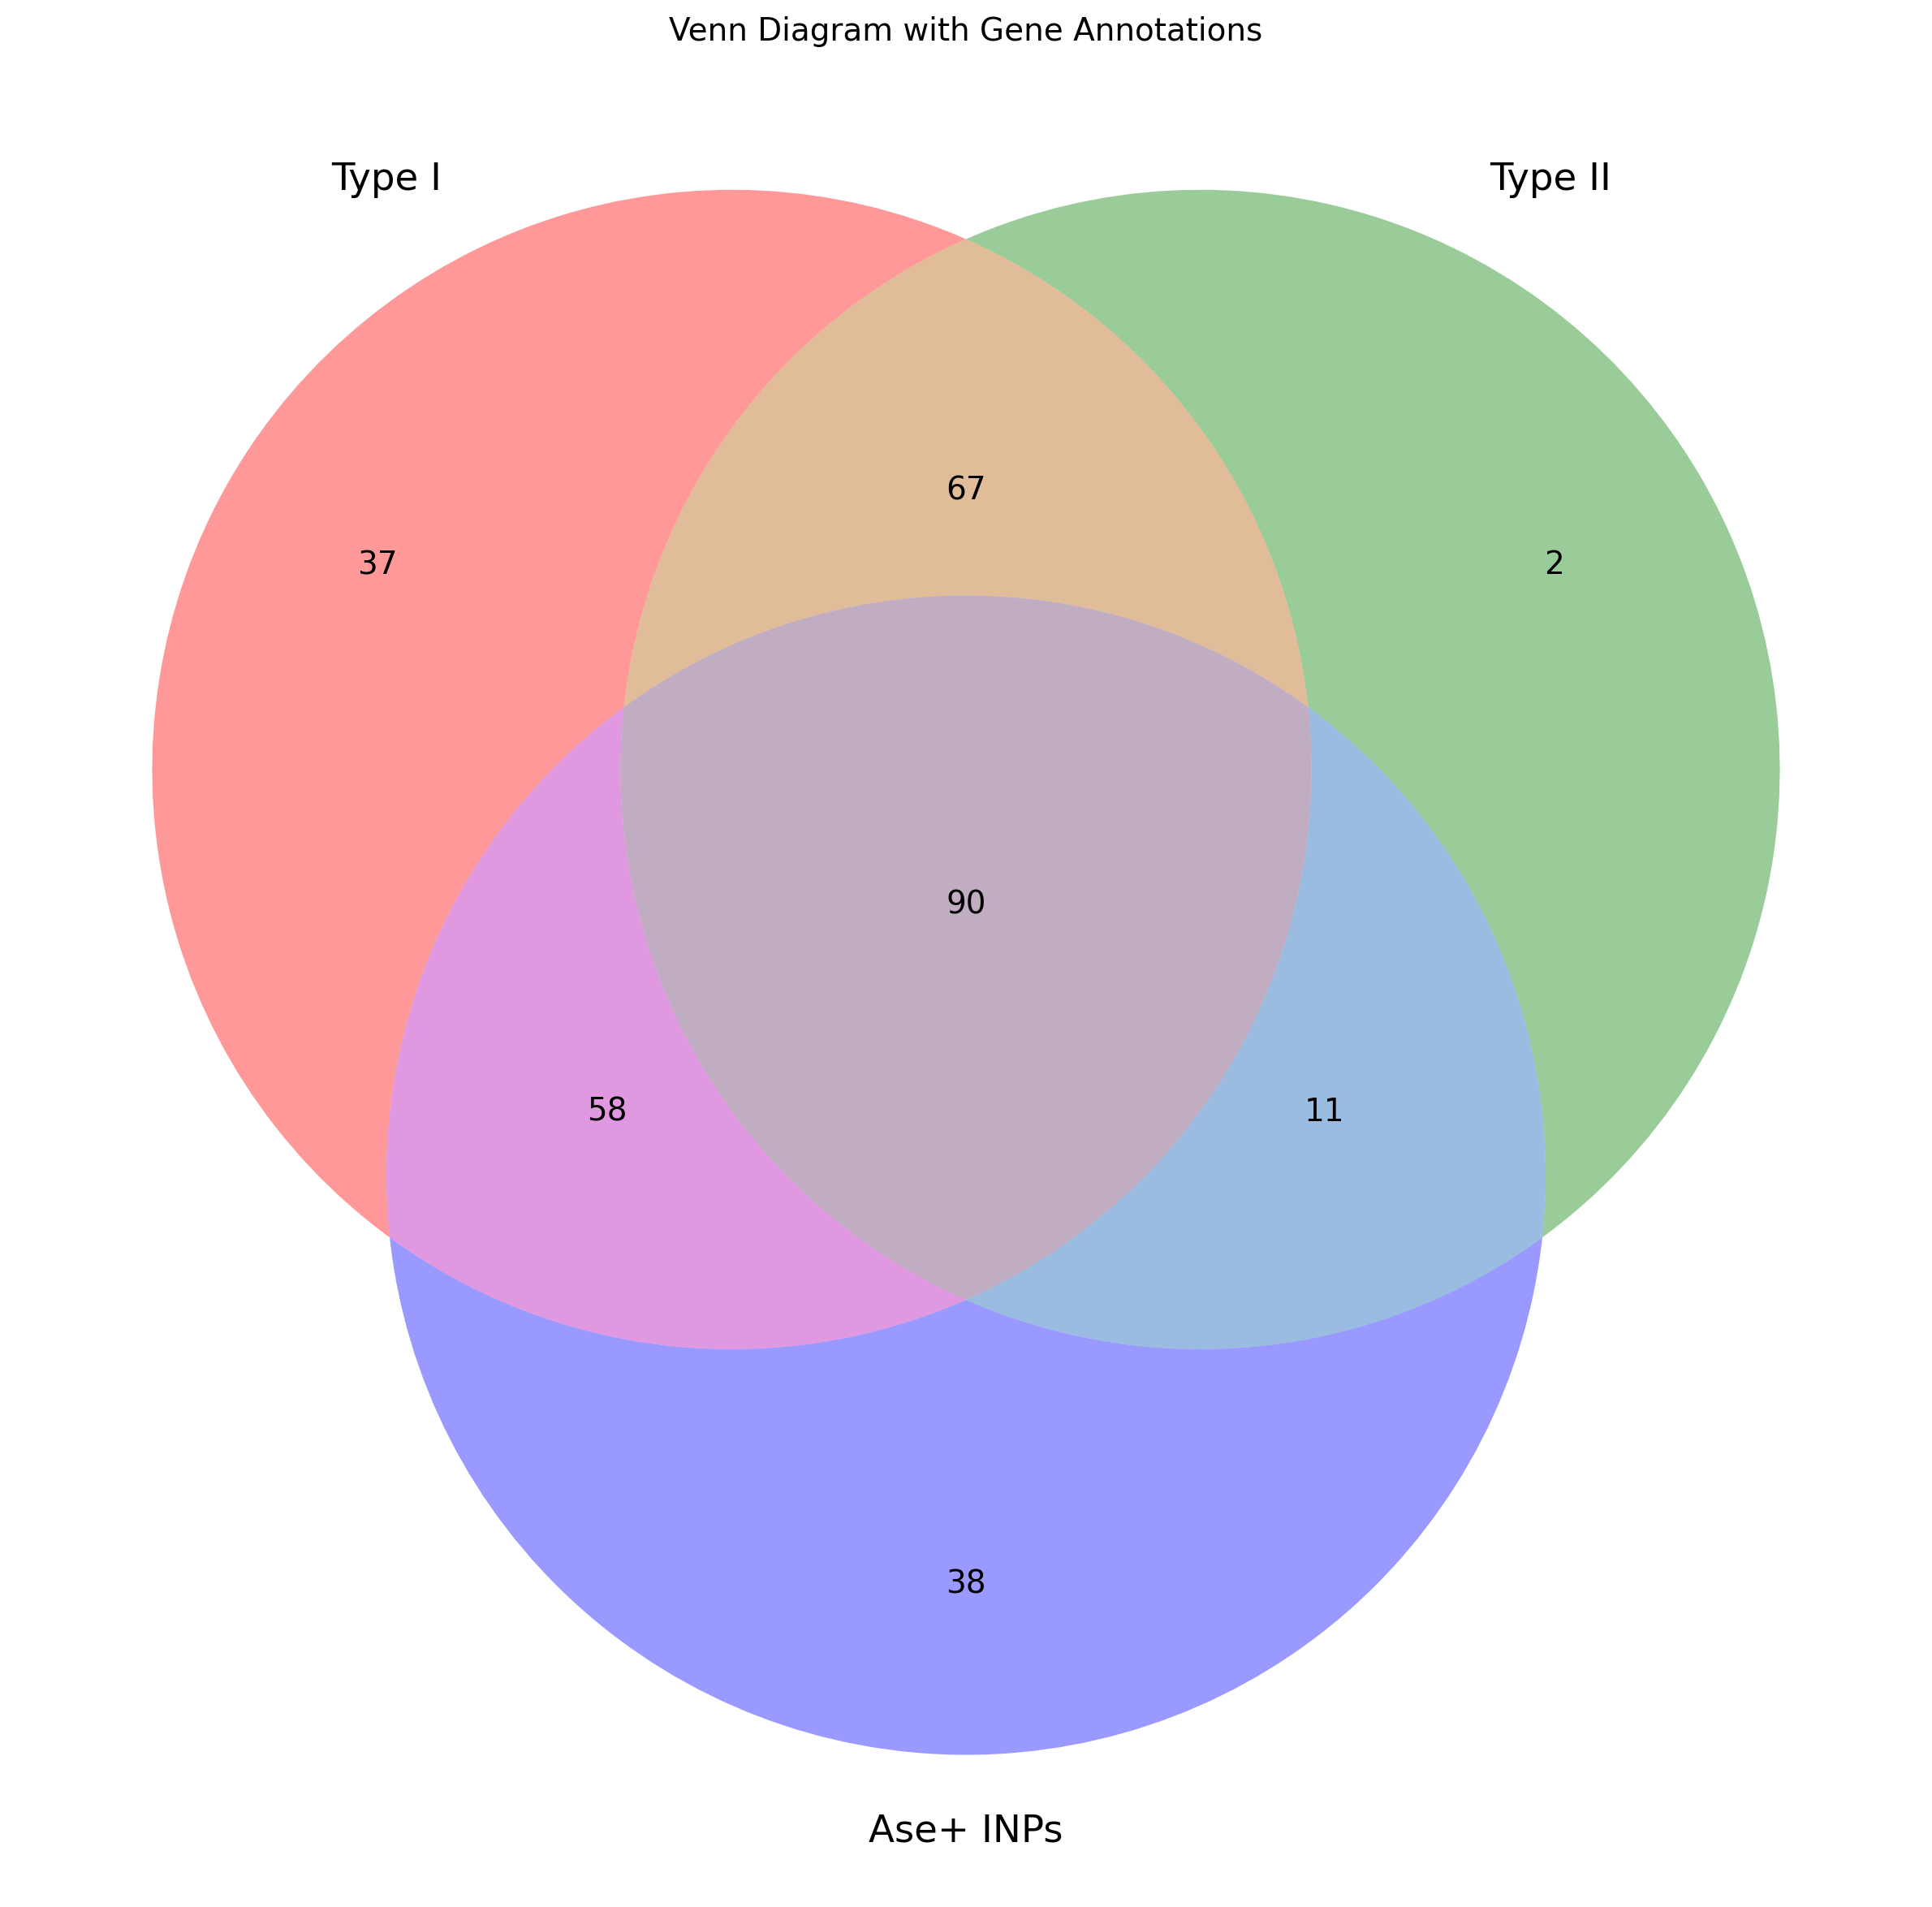

In [16]:
create_annotated_venn(type_I_genes_TF, type_II_genes_TF, asePos_INP_genes_TF.union(INP_genes_TF), 
                      ('Type I', 'Type II', 'Ase+ INPs'))

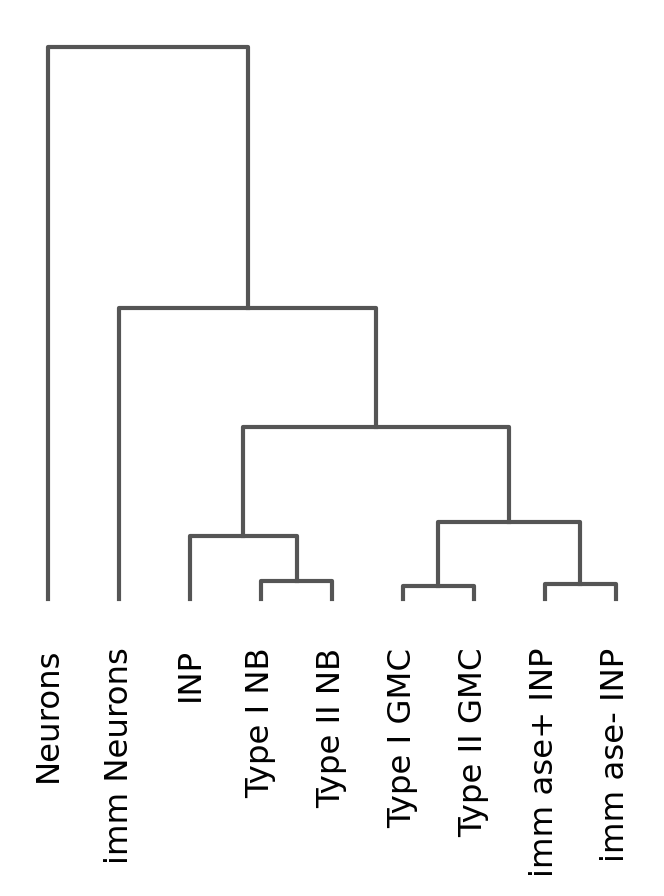

<Axes: >

In [17]:
sc.tl.dendrogram(adata_filtered, groupby="cell_type")
sc.pl.dendrogram(adata_filtered, groupby="cell_type")

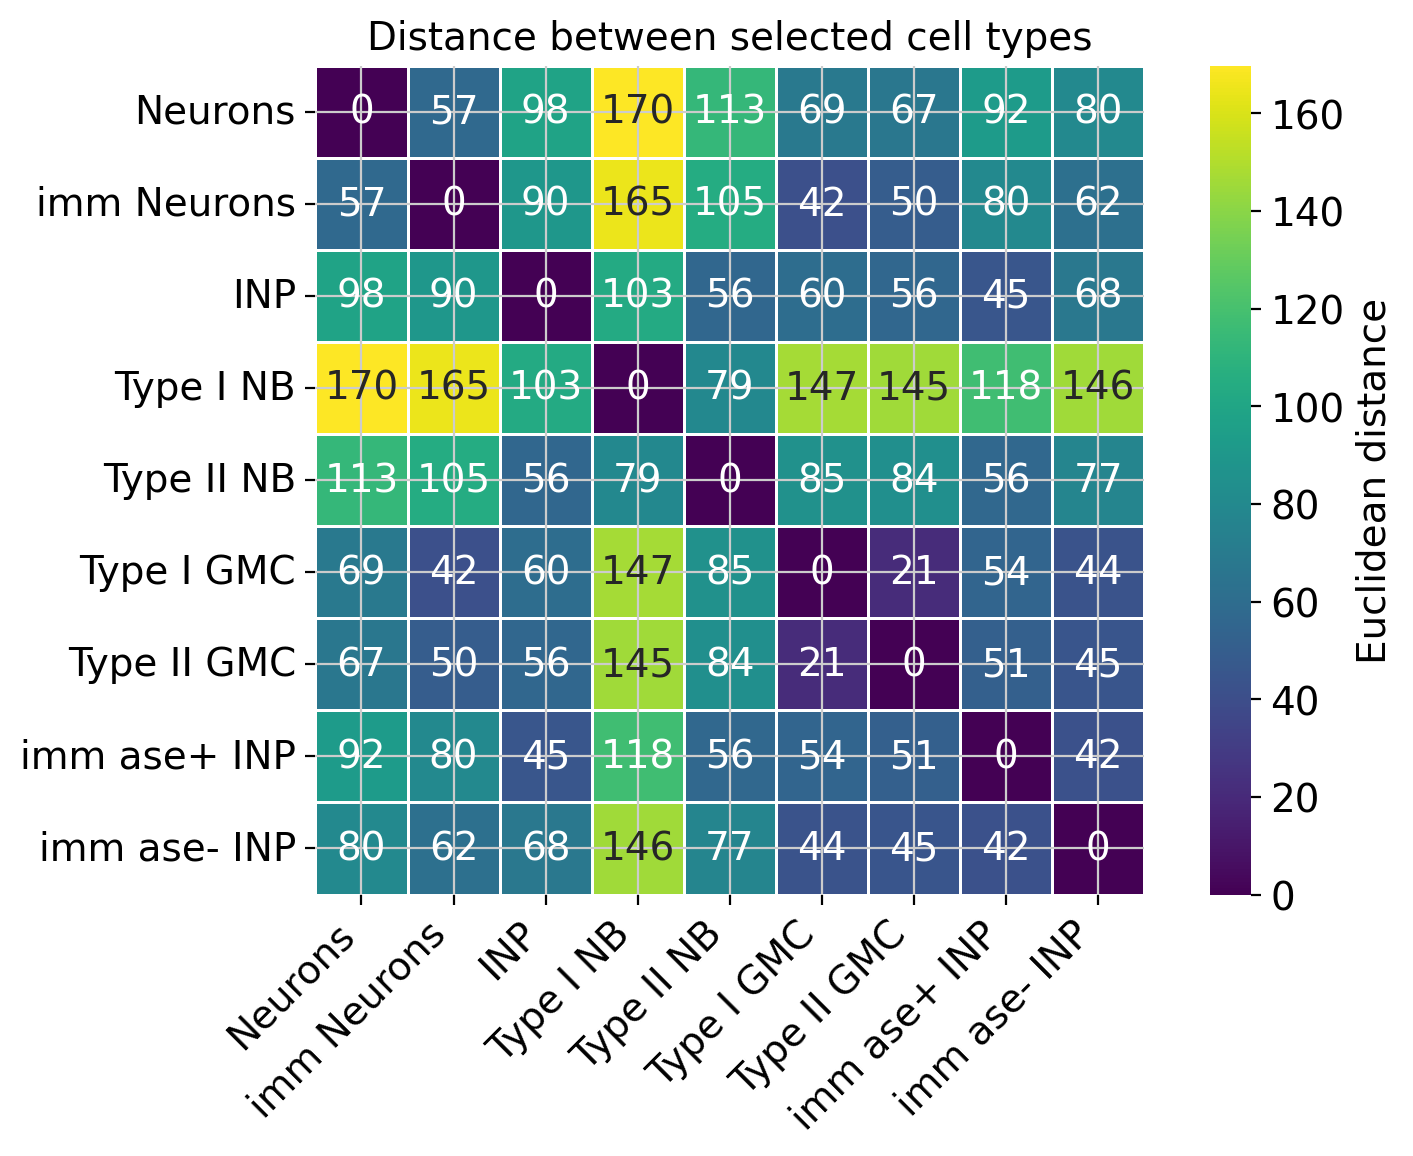

In [19]:
df = adata_filtered.to_df()
df['cell_type'] = adata_filtered.obs['cell_type'].values
avg = df.groupby('cell_type').mean()

order = ['Neurons','imm Neurons', 'INP', 'Type I NB', 'Type II NB', 'Type I GMC', 'Type II GMC', 'imm ase+ INP', 'imm ase- INP']

avg_order = avg.loc[order]

# 4) compute distances on just that subset
dist_matrix = pd.DataFrame(
    squareform(pdist(avg_order.values, metric='euclidean')),
    index=order,
    columns=order
)

# 5) plot the heatmap for only those
plt.figure(figsize=(8,6))
sns.heatmap(
    dist_matrix,
    cmap='viridis',            
    square=True,               
    linewidths=0.5,            
    annot=True,                
    fmt=".0f",                 
    cbar_kws={'label': 'Euclidean distance'},
    xticklabels=dist_matrix.columns,
    yticklabels=dist_matrix.index
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Distance between selected cell types')
plt.tight_layout()
plt.show()